# Quantum Wave Visualizer

In [16]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.animation import FuncAnimation
from scipy.linalg import eigh
from scipy.sparse import diags

sns.set_theme(style="whitegrid")  # Set style

In [17]:
# ========== Costants ==========
hbar = 1.0  # Reduced Planck's constant (in natural units)
m = 1.0  # Mass of the particle (in natural units)


In [18]:
def define_grid(grid_size, x_min, x_max):
	"""
    Define the spatial grid and return the grid points and step size.
    
    Parameters:
        grid_size (int): Number of grid points (-1)
        x_min (float): Minimum value of spatial coordinate
        x_max (float): Maximum value of spatial coordinate
    
    Returns:
        tuple: A tuple containing:
            - x (numpy.ndarray): Array of evenly spaced grid points
            - dx (float): Grid spacing

    Example:
        >>> x, dx = define_grid(100, -5, 5)
        >>> print(len(x)) # Number of points
        101
        >>> print(dx) # Grid spacing
        0.1
    """
	x = np.linspace(x_min, x_max, grid_size + 1)
	dx = (x_max - x_min) / grid_size
	return x, dx


In [19]:
# ========== Define potentials ==========
def potential_square_well(x, well_width, well_depth):
	"""
    Define a square-well potential centered at x=0.
    
    Parameters:
        x (numpy.ndarray): Spatial grid points
        well_width (float): Width of the potential well
        well_depth (float): Depth of the potential well (positive value)
        
    Returns:
        numpy.ndarray: Potential values at each point in x, where V=-well_depth inside 
        the well and V=0 outside
    """
	V = np.zeros_like(x)
	V[np.abs(x) <= well_width / 2] = -well_depth
	return V


def potential_harmonic_oscillator(x, k=1, x0=0):
	"""
    Define a harmonic oscillator potential V(x) = 1/2 * k * (x-x0)^2.
    
    Parameters:
        x (numpy.ndarray): Spatial grid points
        k (float): Spring constant/stiffness, defaults to 1
        x0 (float): Equilibrium position, defaults to 0
        
    Returns:
        numpy.ndarray: Harmonic oscillator potential values at each point in x
    """
	return 0.5 * k * (x - x0) ** 2


def potential_free_particle(x):
	"""
    Define a free particle potential (V=0 everywhere).
    
    Parameters:
        x (numpy.ndarray): Spatial grid points
        
    Returns:
        numpy.ndarray: Zero potential everywhere
    """
	return np.zeros_like(x)


def potential_custom(x, custom_func):
	"""
    Define a customizable potential using a function.
    
    Parameters:
        x (numpy.ndarray): Spatial grid points
        custom_func (callable): Function that takes x as input and returns potential values
        
    Returns:
        numpy.ndarray: Custom potential values at each point in x
    """
	return custom_func(x)


In [20]:
# ========== Define wave packets ==========
def gaussian_wave(x, center=0.0, sigma=1.0, k=0.0):
	"""
    Creates a Gaussian wave packet with specified parameters.
    
    Parameters:
        x (numpy.ndarray): Spatial grid points
        center (float): Center position of the wave packet, defaults to 0.0
        sigma (float): Width/spread of the wave packet, defaults to 1.0 
        k (float): Wave number (momentum), defaults to 0.0
        
    Returns:
        numpy.ndarray: Complex-valued Gaussian wave packet
    """
	return np.exp(-((x - center) ** 2) / (2 * sigma ** 2)) * np.exp(1j * k * x)


def square_wave(x, center=0.0, width=2.0, k=0.0):
	"""
    Creates a square wave packet with specified parameters.
    
    Parameters:
        x (numpy.ndarray): Spatial grid points
        center (float): Center position of the wave packet, defaults to 0.0
        width (float): Width of the square wave, defaults to 2.0
        k (float): Wave number (momentum), defaults to 0.0
        
    Returns:
        numpy.ndarray: Complex-valued square wave packet
    """
	psi = np.zeros_like(x, dtype=complex)
	psi[(x > center - width / 2) & (x < center + width / 2)] = 1.0
	return psi * np.exp(1j * k * x)


def triangular_wave(x, center=0.0, width=2.0, k=0.0):
	"""
    Creates a triangular wave packet with specified parameters.
    
    Parameters:
        x (numpy.ndarray): Spatial grid points
        center (float): Center position of the wave packet, defaults to 0.0
        width (float): Base width of the triangle, defaults to 2.0
        k (float): Wave number (momentum), defaults to 0.0
        
    Returns:
        numpy.ndarray: Complex-valued triangular wave packet
    """
	psi = np.zeros_like(x, dtype=complex)
	mask = np.abs(x - center) <= width / 2
	psi[mask] = 1 - np.abs(x[mask] - center) / (width / 2)
	return psi * np.exp(1j * k * x)


def custom_wave(x, custom_func, k=0.0):
	"""
    Creates a wave packet using a custom function and wave number.
    
    Parameters:
        x (numpy.ndarray): Spatial grid points
        custom_func (callable): Function that takes x as input and returns wave amplitude
        k (float): Wave number (momentum), defaults to 0.0
        
    Returns:
        numpy.ndarray: Complex-valued wave packet based on a custom function
    """
	return custom_func(x) * np.exp(1j * k * x)


In [21]:
def construct_hamiltonian(x, dx, V):
	"""
    Construct the Hamiltonian operator as a matrix.

    Parameters:
        x (numpy.ndarray): Spatial grid points
        dx (float): Grid spacing
        V (numpy.ndarray): Potential energy function evaluated at grid points

    Returns:
        numpy.ndarray: Hamiltonian matrix combining kinetic and potential energy terms
        
    Notes:
        The kinetic energy operator is approximated using a 5-point stencil for increased accuracy.
        The potential energy term is added as a diagonal matrix.
        Uses constants hbar (reduced Planck's constant) and m (particle mass) defined globally.
    """
	# ---------- Kinetic energy operator ----------
	N = len(x)
	kinetic_coefficient = -(hbar ** 2) / (24 * m * dx ** 2)

	# Five-point stencil approximation for kinetic operator
	offsets = [-2, -1, 0, 1, 2]
	diagonals = [
		np.full(N - 2, -1),  # Second off-diagonal terms
		np.full(N - 1, 16),  # First off-diagonal terms
		np.full(N, -30),  # Main diagonal
		np.full(N - 1, 16),  # First off-diagonal terms
		np.full(N - 2, -1),  # Second off-diagonal terms
		]

	kinetic = kinetic_coefficient * diags(diagonals, offsets).toarray()

	# ---------- Potential energy operator ----------
	potential = np.diag(V)

	return kinetic + potential


In [22]:
def solve_schrodinger(H):
	"""
    Solve the time-independent Schrödinger equation for eigenvalues/eigenvectors.
    
    Parameters:
        H (numpy.ndarray): Hamiltonian matrix representing the quantum system
        
    Returns:
        tuple: A tuple containing:
            - eigenvalues (numpy.ndarray): Energy eigenvalues of the system
            - eigenvectors (numpy.ndarray): Corresponding energy eigenstates/wavefunctions
    """
	return eigh(H)


In [23]:
def wavefunction_evolution(x, t, eigenvectors, eigenvalues, c_n):
	"""
    Compute the time-evolved wavefunction psi(x, t).
    
    Parameters:
        x (numpy.ndarray): Spatial grid points
        t (float): Time at which to evaluate the wavefunction
        eigenvectors (numpy.ndarray): Matrix of eigenvectors (eigenfunctions)
        eigenvalues (numpy.ndarray): Array of eigenvalues (energies)  
        c_n (numpy.ndarray): Initial state coefficients
        
    Returns:
        numpy.ndarray: Complex wavefunction evaluated at x and t
    """
	# Time-evolve the wavefunction
	psi_t = np.zeros_like(x, dtype=complex)
	for n, (psi_n, E_n) in enumerate(zip(eigenvectors.T, eigenvalues)):
		psi_t += c_n[n] * psi_n * np.exp(-1j * E_n * t / hbar)

	return psi_t


In [24]:
def get_coefficients(x, dx, eigenvectors, initial_wave_func_func):
	"""
    Compute the coefficients of the initial wavefunction projected
    onto the eigenfunctions of the Hamiltonian.

    Parameters:
        x (numpy.ndarray): Spatial grid.
        dx (float): Grid spacing.
        eigenvectors (numpy.ndarray): Eigenfunctions of the system.
        initial_wave_func_func (function): Function defining the initial wavefunction.

    Returns:
        numpy.ndarray: Normalized coefficients for the initial wavefunction.
    """

	# Define the initial wavefunction using the provided function
	phi = initial_wave_func_func(x)

	# Compute projection coefficients
	c_n = np.array(
			[np.sum(phi * eigenvectors[:, i].conj()) * dx for i in
			 range(len(x))]
			)

	# Normalize coefficients
	c_n /= np.sqrt(np.sum(np.abs(c_n) ** 2))

	return c_n

In [25]:
def calculate_expectation_value(x, psi_t, dx):
	"""
    Calculate the expectation value of the position.

    Parameters:
        x (numpy.ndarray): Spatial grid.
        psi_t (numpy.ndarray): Wave function at time t.
        dx (float): Grid spacing.

    Returns:
        float: Expectation value of the position.
    """
	return np.sum(x * np.abs(psi_t) ** 2) * dx

In [26]:
def animate_wavefunction(
		x,
		dx,
		eigenvectors,
		eigenvalues,
		t_max,
		dt,
		initial_wave_func_func,
		V,
		filename=None,
		):
	"""
    Create an animation of the wavefunction's time evolution.

    Parameters:
        x (numpy.ndarray): Spatial grid
        dx (float): Grid spacing
        eigenvectors (numpy.ndarray): Eigenfunctions from the Hamiltonian
        eigenvalues (numpy.ndarray): Eigenvalues from the Hamiltonian
        t_max (float): Total time duration of the animation
        dt (float): Time step for animation
        initial_wave_func_func (function): Function defining the initial wavefunction.
        V (numpy.ndarray): Potential energy function
        filename (str): Optional filename to save the animation
    """

	# ---------- Make the plots ----------
	# Set up the figure
	fig, ax1 = plt.subplots(figsize=(8, 6))
	ax2 = ax1.twinx()

	# Define the lines for psi squared, real and imaginary parts
	(line_abs,) = ax1.plot([], [], label=r"$|\psi(x, t)|^2$", color="blue",
	                       zorder=3)
	(line_real,) = ax1.plot(
			[], [], label=r"$Re(\psi(x, t))^2$", color="red", linestyle=":",
			zorder=2
			)
	(line_imag,) = ax1.plot(
			[], [], label=r"$Im(\psi(x, t))^2$", color="green", linestyle=":",
			zorder=2
			)

	# Define the expectation value line
	expectation_value_line = ax1.axvline(
			x=0, color="r", linestyle="--", label="Expectation Value", zorder=1
			)

	# Plot the potential in the background
	ax2.plot(x, V, color="gray", linestyle="-", zorder=0)
	V_min = np.full(shape=len(V), fill_value=V.min())
	ax2.fill_between(x, V_min, V, color="gray", alpha=0.3)

	# Make the plot fancy
	ax1.set(
			title="Time Evolution of the Wavefunction",
			xlabel="x",
			xlim=(x.min(), x.max()),
			ylim=(0, 1.1),
			)
	ax2.set_ylim(V.min(), V.max() + 0.1)

	ax1.set_ylabel(r"$|\psi(x)|^2$", color="blue")
	ax2.set_ylabel("Potential", color="gray")

	ax1.grid(True, linestyle="--", alpha=0.7)
	ax2.grid(False)

	handles1, labels1 = ax1.get_legend_handles_labels()
	handles2, labels2 = ax2.get_legend_handles_labels()
	ax2.legend(handles1 + handles2, labels1 + labels2, loc="upper right")

	# Add a text element to display the time
	time_text = ax1.text(0.03, 0.93, "", transform=ax1.transAxes)

	# ---------- Define helper functions ----------
	def init():
		"""Initialize the plot."""
		line_abs.set_data([], [])
		line_real.set_data([], [])
		line_imag.set_data([], [])
		expectation_value_line.set_xdata([])
		time_text.set_text("")
		return line_abs, line_real, line_imag, expectation_value_line, time_text

	def update(frame):
		"""Update the wavefunction for the given frame."""
		t = time_points[frame]
		psi_t = wavefunction_evolution(x, t, eigenvectors, eigenvalues,
		                               c_n=c_n)

		# Calculate and update the wavefunction lines
		line_abs.set_data(x, np.abs(psi_t) ** 2)
		line_real.set_data(x, np.real(psi_t) ** 2)
		line_imag.set_data(x, np.imag(psi_t) ** 2)

		# Calculate and update expectation value
		expectation_x = calculate_expectation_value(x, psi_t, dx)
		expectation_value_line.set_xdata([expectation_x])

		# Update the time display
		time_text.set_text(f"Time: {t:.2f}")

		return line_abs, line_real, line_imag, expectation_value_line, time_text

	# ---------- Animation ----------
	# Define animation parameters
	time_points = np.arange(0, t_max + dt, dt, dtype=float)
	c_n = get_coefficients(x, dx, eigenvectors, initial_wave_func_func)

	# Create animation
	anim = FuncAnimation(fig, update, frames=int(t_max / dt), init_func=init,
	                     blit=True)

	# Save animation
	if filename:
		anim.save(filename, writer="ffmpeg", fps=30)

In [27]:
def plot_starting_conditions(x, initial_wavefunction, V, eigenvalues,
                             eigenvectors, num_eigenfunctions=5):
	"""
    Plots the initial wavefunction, potential, and the first few eigenfunctions.

    Parameters:
        x (numpy.ndarray): Spatial grid.
        initial_wavefunction (numpy.ndarray): Initial wavefunction.
        V (numpy.ndarray): Potential energy function.
        eigenvalues (numpy.ndarray): Eigenvalues of the system.
        eigenvectors (numpy.ndarray): Eigenvectors of the system.
        num_eigenfunctions (int): Number of eigenfunctions to plot.
    """

	# Set up the figure
	fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))
	plt.suptitle("Starting Conditions")

	# Plot the initial wavefunction
	ax1.plot(x, np.abs(initial_wavefunction) ** 2,
	         label="Initial Wavefunction")
	ax1.set_title("Initial Wavefunction")
	ax1.set_xlabel("x")
	ax1.set_ylabel(r"$\psi^2(x)$")

	# Plot the potential
	ax2.plot(x, V, label="Potential")
	ax2.set_title("Potential")
	ax2.set_xlabel("x")
	ax2.set_ylabel("V(x)")

	# Plot the eigenfunctions
	for i in range(num_eigenfunctions):
		ax3.plot(x, np.real(eigenvectors[:, i]),
		         label=f"Eigenfunction {i + 1} (E={eigenvalues[i]:.2f})")
	ax3.set_title("Eigenfunctions")
	ax3.set_xlabel("x")
	ax3.set_ylabel(r"$\psi(x)$")

	# Make the plot fancy
	plt.legend()
	plt.tight_layout()
	plt.show()

In [28]:
def normalize_eigenvectors(eigenvectors, dx):
	"""
    Normalize the eigenvectors of the Hamiltonian.
    
    Parameters:
        eigenvectors (numpy.ndarray): Eigenvectors to normalize
        
    Returns:
        numpy.ndarray: Normalized eigenvectors where each column is normalized 
        such that integral |psi|^2 dx = 1
    """
	for i in range(eigenvectors.shape[1]):
		eigenvectors[:, i] /= np.sqrt(
			np.sum(np.abs(eigenvectors[:, i]) ** 2) * dx)
	return eigenvectors


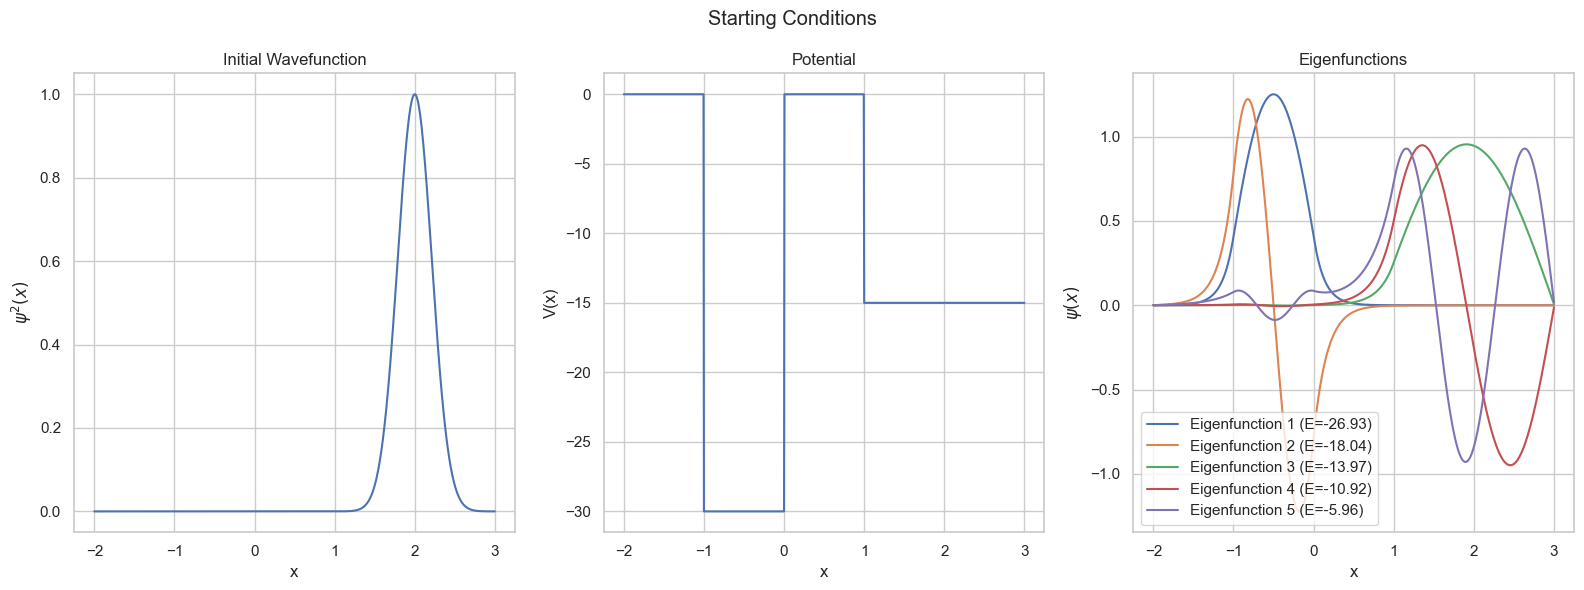

In [30]:
def main():
	# ---------- Animation parameters ----------
	grid_size = 1000
	x_min, x_max = -2, 3
	t_max = 5.0
	dt = 0.005


	starting_wave_func = partial(gaussian_wave, center=2, sigma=0.3)

	x, dx = define_grid(grid_size, x_min, x_max)

	def multiwell(x):
		V = np.zeros_like(x)
		V[np.abs(x + 0.5) <= 1 / 2] = -30
		V[np.abs(x - 2) <= 2 / 2] = -15
		return V

	V = potential_custom(x, multiwell)


	H = construct_hamiltonian(x, dx, V)

	eigenvalues, eigenvectors = solve_schrodinger(H)
	eigenvectors = normalize_eigenvectors(eigenvectors, dx)

	plot_starting_conditions(x, starting_wave_func(x), V, eigenvalues, eigenvectors)

	animate_wavefunction(
			x,
			dx,
			eigenvectors,
			eigenvalues,
			t_max,
			dt,
			starting_wave_func,
			V,
			filename="wavefunction.mp4",
			)


if __name__ == "__main__":
	main()